In [1]:
import sys, os

sys.path.insert(1, os.path.join(sys.path[0], '..\..'))

from FwtModels import AssumedShapes
import numpy as np
import sympy as sym
import sympy.physics.mechanics as me
from sympy.abc import y,x,t
import pandas as pd

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from scipy.linalg import eig

plt.style.use('seaborn')

# 2 Bending 2 Torsion, Continous Beam

In [3]:
semiSpan = 1.345  # semi-span of the wing
ratioFwt = 0   # ratio of the wing semi span that is fwt
wingMass = 2.75   # mass of entire semi-span wing
chord = 0.15

mu = wingMass/(chord*semiSpan) # mass density of the wing

In [4]:
# with width b and hieght h
h = 0.005 # hieght of bar
b = 0.03 # width of bar
I_xx = b*h**3/12
I_yy = b**3*h/12
J = I_xx + I_yy

# Material properties
E = 190e9
G = 74e9

In [8]:
E*I_xx

In [9]:
G*J

In [10]:
# create an instance of the class holding all the properties for the FWT
p = AssumedShapes.FwtParameters(m_w = mu,
                        m_t = mu,
                        x_f = 0.5,
                        s_w = semiSpan*(1-ratioFwt),
                        s_t = semiSpan*ratioFwt,
                        c = chord,
                        Lambda = np.deg2rad(10),
                        EI = E*I_xx,
                        GJ = G*J,
                        k_theta = 0,
                        rho = 1.225,
                        V = 10,
                        a_w = 2*np.pi,
                        a_t = 2*np.pi,
                        alpha_0 = 0,
                        e = 0.25,
                        Malphadot = -1.2,
                        g = 9.81)

In [13]:
# create generalised coordinates
q0,q1,q2,q3 = me.dynamicsymbols('q:4') 
q = sym.Matrix([q0,q1,q2,q3])


## create model

# define shape Functions
z_w = q0*y**2+q1*y**3+q2*y*(x-p.x_f)+q3*y**2*(x-p.x_f)
alpha_w = q2*y+q3*y**2

#z_w = q0*y**2+q1*y*(x-p.x_f)
#alpha_w = q1*y


# FWT 
z_t = z_w.subs(y,p.s_w)
alpha_t = alpha_w.subs(y,p.s_w)

# create the model
sModel = AssumedShapes.SymbolicModel(q,z_w,alpha_w,z_t,alpha_t,p)
sModel.GenerateEoM()

# create numeric Model (leaving V as an unknown)
variables = list(p.GetTuple())
variables.remove(p.V)

nModel = sModel.createNumericInstance(tuple(variables))

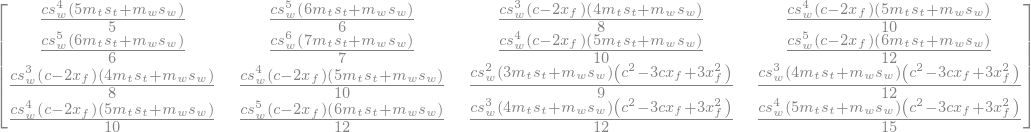

In [14]:
sModel.M

In [15]:
nModel.M

array([[ 1.20000000e+05,  1.10000000e+06, -5.73750000e+03,
        -5.10000000e+04],
       [ 1.10000000e+06,  1.02857143e+07, -5.10000000e+04,
        -4.67500000e+05],
       [-5.73750000e+03, -5.10000000e+04,  2.92000000e+02,
         2.46375000e+03],
       [-5.10000000e+04, -4.67500000e+05,  2.46375000e+03,
         2.19000000e+04]])

In [6]:
from IPython.display import display, Markdown
from sympy.physics.vector.printing import vlatex
sym.simplify(sModel.G_w+sModel.G_t)
sModel.PrintE0M()


#sym.Mul(sModel.M,sModel.qdd,Evalute=False)

'\\left[\\begin{matrix}\\frac{c s_{w}^{4} \\left(5 m_{t} s_{t} + m_{w} s_{w}\\right)}{5} & \\frac{c s_{w}^{5} \\left(6 m_{t} s_{t} + m_{w} s_{w}\\right)}{6} & \\frac{c s_{w}^{3} \\left(c - 2 x_{f}\\right) \\left(4 m_{t} s_{t} + m_{w} s_{w}\\right)}{8} & \\frac{c s_{w}^{4} \\left(c - 2 x_{f}\\right) \\left(5 m_{t} s_{t} + m_{w} s_{w}\\right)}{10}\\\\\\frac{c s_{w}^{5} \\left(6 m_{t} s_{t} + m_{w} s_{w}\\right)}{6} & \\frac{c s_{w}^{6} \\left(7 m_{t} s_{t} + m_{w} s_{w}\\right)}{7} & \\frac{c s_{w}^{4} \\left(c - 2 x_{f}\\right) \\left(5 m_{t} s_{t} + m_{w} s_{w}\\right)}{10} & \\frac{c s_{w}^{5} \\left(c - 2 x_{f}\\right) \\left(6 m_{t} s_{t} + m_{w} s_{w}\\right)}{12}\\\\\\frac{c s_{w}^{3} \\left(c - 2 x_{f}\\right) \\left(4 m_{t} s_{t} + m_{w} s_{w}\\right)}{8} & \\frac{c s_{w}^{4} \\left(c - 2 x_{f}\\right) \\left(5 m_{t} s_{t} + m_{w} s_{w}\\right)}{10} & \\frac{c s_{w}^{2} \\left(3 m_{t} s_{t} + m_{w} s_{w}\\right) \\left(c^{2} - 3 c x_{f} + 3 x_{f}^{2}\\right)}{9} & \\frac{c s_{w}

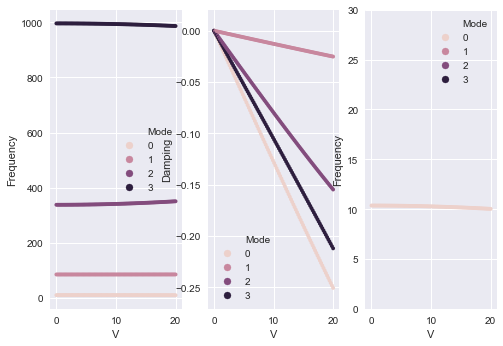

,V,Frequency,Damping,Mode
0,0.0,10.359987,7.273662e-16,0
1,0.0,85.207397,-1.493080e-15,1
2,0.0,338.041496,9.387106e-15,2
3,0.0,995.972282,2.604045e-14,3


In [19]:
me.mechanics_printing()
Mp = sym.lambdify(p.V,nModel.MprimeSym(),[{'sqrt':np.lib.scimath.sqrt},'numpy'])
Kp = sym.lambdify(p.V,nModel.KprimeSym(),[{'sqrt':np.lib.scimath.sqrt},'numpy'])
V = np.linspace(0,20,100)
dps = []
for i in range(0,len(V)):
    evals,evecs = eig(Kp(V[i]),Mp(V[i]))
    _,ind = np.unique(np.round(np.abs(evals),4),return_index=True)
    evals = evals[ind]
    for j in range(0,len(evals)):
        dps.append([V[i],np.abs(evals[j]),np.cos(np.angle(evals[j])),j])

df = pd.DataFrame(data = dps,columns=['V','Frequency','Damping','Mode'])


f, axes = plt.subplots(1, 3)
sns.scatterplot(x="V",y="Frequency",hue="Mode",data=df,ax=axes[0],s = 15,linewidth=0)
sns.scatterplot(x="V",y="Damping",hue="Mode",data=df,ax=axes[1],s =15,linewidth = 0)
sns.scatterplot(x="V",y="Frequency",hue="Mode",data=df,ax=axes[2],s = 15,linewidth=0)
axes[2].set(ylim=(0,30))
plt.show()
df[df['V']==0]